In [1]:
# HIDE CODE
from dateutil.relativedelta import relativedelta
from joblib import dump, load
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams.update({'font.size': 12})


import warnings
import sys
import os
sys.path.append('/home/server/gli-data-science/')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

import os
import ds_db
import helper_db
from helper import transform_to_rupiah, rupiah_format

import pickle
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import display, HTML, display_html, IFrame
import ipywidgets as ipyw

def side_by_side_display(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    styles = [
        dict(selector="caption", props=[("caption-side", "center"), ("font-size", "100%"), ("color", )])]
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline; font-size:85%' ").set_precision(2).set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0\xa0"

    display(HTML(output))

    
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, PoissonRegressor, Ridge, Lasso, RANSACRegressor, RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, export_text, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR, SVC, LinearSVC
import xgboost as xgb 


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split


import textwrap
def split_label(list_label):
    list_label = list(list_label)
    list_label = ["<br>".join(textwrap.wrap(t, width=12)) for t in list_label ]
    return list_label

### ide kasar
> 
* daily job to loop all member alfagift 10 juta
* compute feature trx voucher used, # of trx, # of sales
* compute feature event app site open / view product / atc
* updating each feature and re predict churn feature
* lets play in month - 3 for each define trx and event feature

In [2]:
df_pv_ = pd.read_csv('./pv_31Dec21.csv')
df_pv_['EVENT_TIME'] = pd.to_datetime(df_pv_['EVENT_TIME']).dt.strftime('%Y-%m')

df_pv = df_pv_.groupby(['TRO_MEMBERS','EVENT_TIME']).agg(PV=('COUNT_VIEW_PRODUCT','sum'))\
        .unstack(level=1).fillna(0).reset_index()

df_pv.columns = [' '.join(col).strip().upper() for col in df_pv.columns.values]

In [3]:
df_pv.head()

,TRO_MEMBERS,PV 2021-08,PV 2021-09,PV 2021-10,PV 2021-11,PV 2021-12
0,9990010000001200,22.0,25.0,27.0,46.0,38.0
1,9990010000001999,2.0,0.0,0.0,0.0,0.0
2,9990010000004582,0.0,0.0,6.0,0.0,0.0
3,9990010000008534,0.0,0.0,4.0,0.0,0.0
4,9990010000031123,0.0,0.0,0.0,1.0,1.0


In [ ]:
# from datetime import datetime
# now = datetime.now()
# now_ = datetime(now.year, now.month, now.day)
# ## 9990010000070044
# # sample with minus

# q = '''

# select 
#     ttdr.tbtdr_created_date, 
#     ttdr.tbtdr_ponta_user AS TRO_MEMBERS, 
#     ttdr.tbtdr_tbto_id, 
#     ttdr.tbtdr_rating AS rating
# from 
#     tb_transaction_delivery_rating ttdr 
# where 
#     ttdr.tbtdr_created_date between '2021-08-01' and '2022-01-01'
#     and ttdr.tbtdr_rating > 0
# '''.format(now_)

# con, cur = ds_db.connect_prd_order_4()
# df_re = pd.read_sql(q, con)


# con.close()

# df_re['created_date'] = df_re['tbtdr_created_date'].dt.strftime('%Y-%m')
# df_re = df_re[df_re['tro_members'] != '']

# ## groupby and get feature by rating below good and rating avg
# df_re_g = df_re.groupby(['tro_members', 'created_date']).agg(
#                                 rating_below = ('rating', lambda x: len(x[x<3])),
#                                 rating_avg = ('rating','mean')
#                             )
# df_re_g_u = df_re_g.unstack(level=1).fillna(0).reset_index()
# df_re_g_u.columns = [' '.join(col).strip().upper() for col in df_re_g_u.columns.values]

# df_re_g_u.head(20)

In [ ]:
# df_re['tbtdr_created_date'].min(), df_re['tbtdr_created_date'].max()

In [4]:
df_re_g_u = pd.read_csv('./rating_2022-01-01.csv')

In [5]:
# HIDE CODE

## USING ORDER
import glob

df_tto = []
for end_date in pd.date_range('2021-08-01', '2022-01-01', freq='M'):
    start_date = end_date.replace(day=1)
    end_date_save = start_date + relativedelta(months=1)
    
    start_date_str = start_date.strftime('%d%b%y')
    end_date_str = end_date_save.strftime('%d%b%y')
    
    print(start_date_str, end_date_str)
    
    pf = '/home/server/gli-data-science/data/trans_oshop/{}_{}.csv'.format(start_date_str, end_date_str)
    df_tto.append(pd.read_csv(pf, sep='\t', dtype='object'))
    
df_tto = pd.concat(df_tto)

df_tto = df_tto[df_tto['TRO_MEMBERS'] != 'N']
df_tto['TRO_DATE'] = pd.to_datetime(df_tto['TRO_DATE'])
df_tto['TRO_NET'] = df_tto['TRO_NET'].astype('float', errors='ignore').astype('int', errors='ignore')


df_tto['TRO_QTY'] = df_tto['TRO_QTY'].astype(int)

01Aug21 01Sep21
01Sep21 01Oct21
01Oct21 01Nov21
01Nov21 01Dec21
01Dec21 01Jan22


In [6]:
# df_tto['TRO_VOUCHER_USAGE'] = df_tto['TRO_VOUCHER_USAGE'].astype('float', errors='ignore').astype('int', errors='ignore')
df_tto['TRO_DATE_MONTH'] = df_tto['TRO_DATE'].dt.strftime('%Y-%m')

In [7]:
df_tto_sel = df_tto[(df_tto['TRO_DATE'] >= '2021-09-01') \
            & (df_tto['TRO_DATE'] <= '2021-12-31')]

In [9]:
df_sla = pd.read_csv('./sla_31Dec21.csv')
df_sla['ATT_SEND_DATE_TOSTORE'] = pd.to_datetime(df_sla['ATT_SEND_DATE_TOSTORE'])
df_sla['SLA'] = np.where(df_sla['SLA_NORM']< 0, 20, df_sla['SLA_NORM'])

In [10]:
df_tto_sel = pd.merge(df_tto_sel, df_sla, left_on='TRO_NO_ORDER', right_on='ATT_ORDER_ID', how='left')
df_tto_sel = df_tto_sel.drop(['ATT_ORDER_ID','ATT_ORDER_DATE','ATT_DELIVERY_DATE','ATT_SEND_DATE_TOSTORE','SLA_NORM'],1)

In [11]:
df_tto_sel['SLA'] = df_tto_sel['SLA'].fillna(20)
df_tto_sel['SLA_LATE'] = np.where(df_tto_sel['SLA'] > 60, 1,0)

In [12]:
df_tto_sel[df_tto_sel['SLA'].notnull()].head()

,TRO_DATE,TRO_CART_ID,TRO_KD_STORE,TRO_BRANCH_CODE,BRANCH_CODE,TRO_MEMBERS,TRO_NO_ORDER,TRO_PLU,TRO_QTY,TRO_VOUCHER_USAGE,TRO_PAYMENT_METHOD,TRO_NET,TRO_SHIP_METHOD,TRO_STATUS_SAPA,TRO_STATUS_RETUR,TRO_DATE_MONTH,SLA,SLA_LATE
0,2021-09-05,10873363,CG09,CZ01,CZ01,9990013363654765,O-210905-AGMCRTZ,124628,1,0.0,sat-cod,55000,1,Y,N,2021-09,6.7,0
1,2021-09-05,10873363,CG09,CZ01,CZ01,9990013363654765,O-210905-AGMCRTZ,174590,1,0.0,sat-cod,4636,1,Y,N,2021-09,6.7,0
2,2021-09-05,10873363,CG09,CZ01,CZ01,9990013363654765,O-210905-AGMCRTZ,176010,1,0.0,sat-cod,4636,1,Y,N,2021-09,6.7,0
3,2021-09-05,10873363,CG09,CZ01,CZ01,9990013363654765,O-210905-AGMCRTZ,219707,1,0.0,sat-cod,10454,1,Y,N,2021-09,6.7,0
4,2021-09-05,10854981,CG10,CZ01,CZ01,9990013137230742,O-210905-AGBTPCB,103002,1,0.0,shopeepay,181,0,N,N,2021-09,1592.4,1


In [13]:
df_tto_sel_g = df_tto_sel.groupby(['TRO_MEMBERS','TRO_DATE_MONTH','TRO_NO_ORDER'])\
                        .agg({'TRO_NET':'sum',
                              'TRO_NO_ORDER':'nunique',
                              'SLA':'first',
                              'SLA_LATE':'first'
                             })
df_tto_sel_g = df_tto_sel_g.groupby(['TRO_MEMBERS','TRO_DATE_MONTH'])\
                        .agg({'TRO_NET':'sum',
                              'TRO_NO_ORDER':'sum',
                              'SLA':'sum',
                              'SLA_LATE':'sum'
                             })

In [14]:
df_tto_sel_g_u = df_tto_sel_g.unstack(level=1).fillna(0).reset_index()
df_tto_sel_g_u.columns = [' '.join(col).strip().upper() for col in df_tto_sel_g_u.columns.values]

In [16]:
df_re_g_u['TRO_MEMBERS'] = df_re_g_u['TRO_MEMBERS'].astype(str)

In [17]:
df_tto_re = pd.merge(df_tto_sel_g_u, df_re_g_u, on='TRO_MEMBERS', how='left').fillna(0)

In [18]:
df_tto_re.head()

,TRO_MEMBERS,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA 2021-12,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,SLA_LATE 2021-12,RATING_BELOW 2021-08,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_BELOW 2021-12,RATING_AVG 2021-08,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,RATING_AVG 2021-12
0,006506519712,0.0,0.0,50362.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9990010000001200,1791590.0,2412654.0,3117811.0,3217556.0,20.0,35.0,49.0,40.0,217.1,480.8,630.1,710.1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9990010000004582,0.0,191267.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,9951.7,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9990010000008534,202358.0,644400.0,165315.0,776032.0,4.0,10.0,3.0,8.0,73.3,214.9,93.3,159.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9990010000031123,0.0,0.0,412904.0,48908.0,0.0,0.0,4.0,1.0,0.0,0.0,34.6,359.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_pv['TRO_MEMBERS'] = df_pv['TRO_MEMBERS'].astype(str)
df_tto_re_pv = pd.merge(df_tto_re, df_pv, on='TRO_MEMBERS', how='left').fillna(0)

In [20]:
df_tto_re_pv['NET_11-10'] = df_tto_re_pv['TRO_NET 2021-11'] - df_tto_re_pv['TRO_NET 2021-10']
df_tto_re_pv['NET_10-09'] = df_tto_re_pv['TRO_NET 2021-10'] - df_tto_re_pv['TRO_NET 2021-09']
df_tto_re_pv['NET_11-09'] = df_tto_re_pv['TRO_NET 2021-11'] - df_tto_re_pv['TRO_NET 2021-09']
df_tto_re_pv['STRUK_11-10'] = df_tto_re_pv['TRO_NO_ORDER 2021-11'] - df_tto_re_pv['TRO_NO_ORDER 2021-10']
df_tto_re_pv['STRUK_10-09'] = df_tto_re_pv['TRO_NO_ORDER 2021-10'] - df_tto_re_pv['TRO_NO_ORDER 2021-09']
df_tto_re_pv['STRUK_11-09'] = df_tto_re_pv['TRO_NO_ORDER 2021-11'] - df_tto_re_pv['TRO_NO_ORDER 2021-09']

In [21]:
# print(df_ins[df_ins['label'] == 1]['NET_11-10'].median())
# print(df_ins[df_ins['label'] == 1]['NET_10-09'].median())
# print(df_ins[df_ins['label'] == 1]['NET_11-09'].median())
# print(df_ins[df_ins['label'] == 1]['STRUK_11-10'].mean())
# print(df_ins[df_ins['label'] == 1]['STRUK_10-09'].mean())
# print(df_ins[df_ins['label'] == 1]['STRUK_11-09'].mean())

In [ ]:
# clf_ridge = DecisionTreeClassifier(random_state=0, max_depth=15) 
# clf_ridge.fit(X_train, y_train) 
# pred = clf_ridge.predict(X_test)

# print(classification_report(y_test, pred))
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

### RANDOM FOREST

### not oversampling version without threshold 2/3

              precision    recall  f1-score   support

           0       0.94      0.99      0.96    189343
           1       0.53      0.23      0.32     14173

    accuracy                           0.93    203516
   macro avg       0.74      0.61      0.64    203516
weighted avg       0.92      0.93      0.92    203516



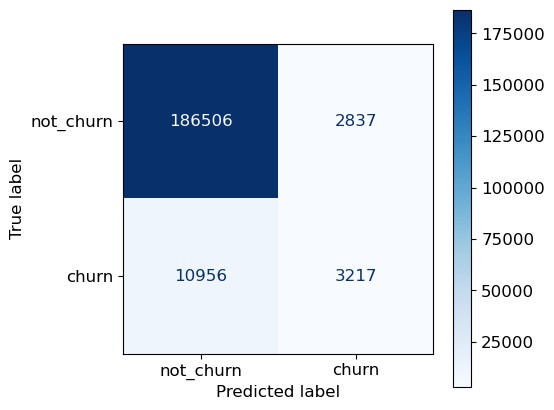

In [22]:
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = RandomForestClassifier(random_state=42) 
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

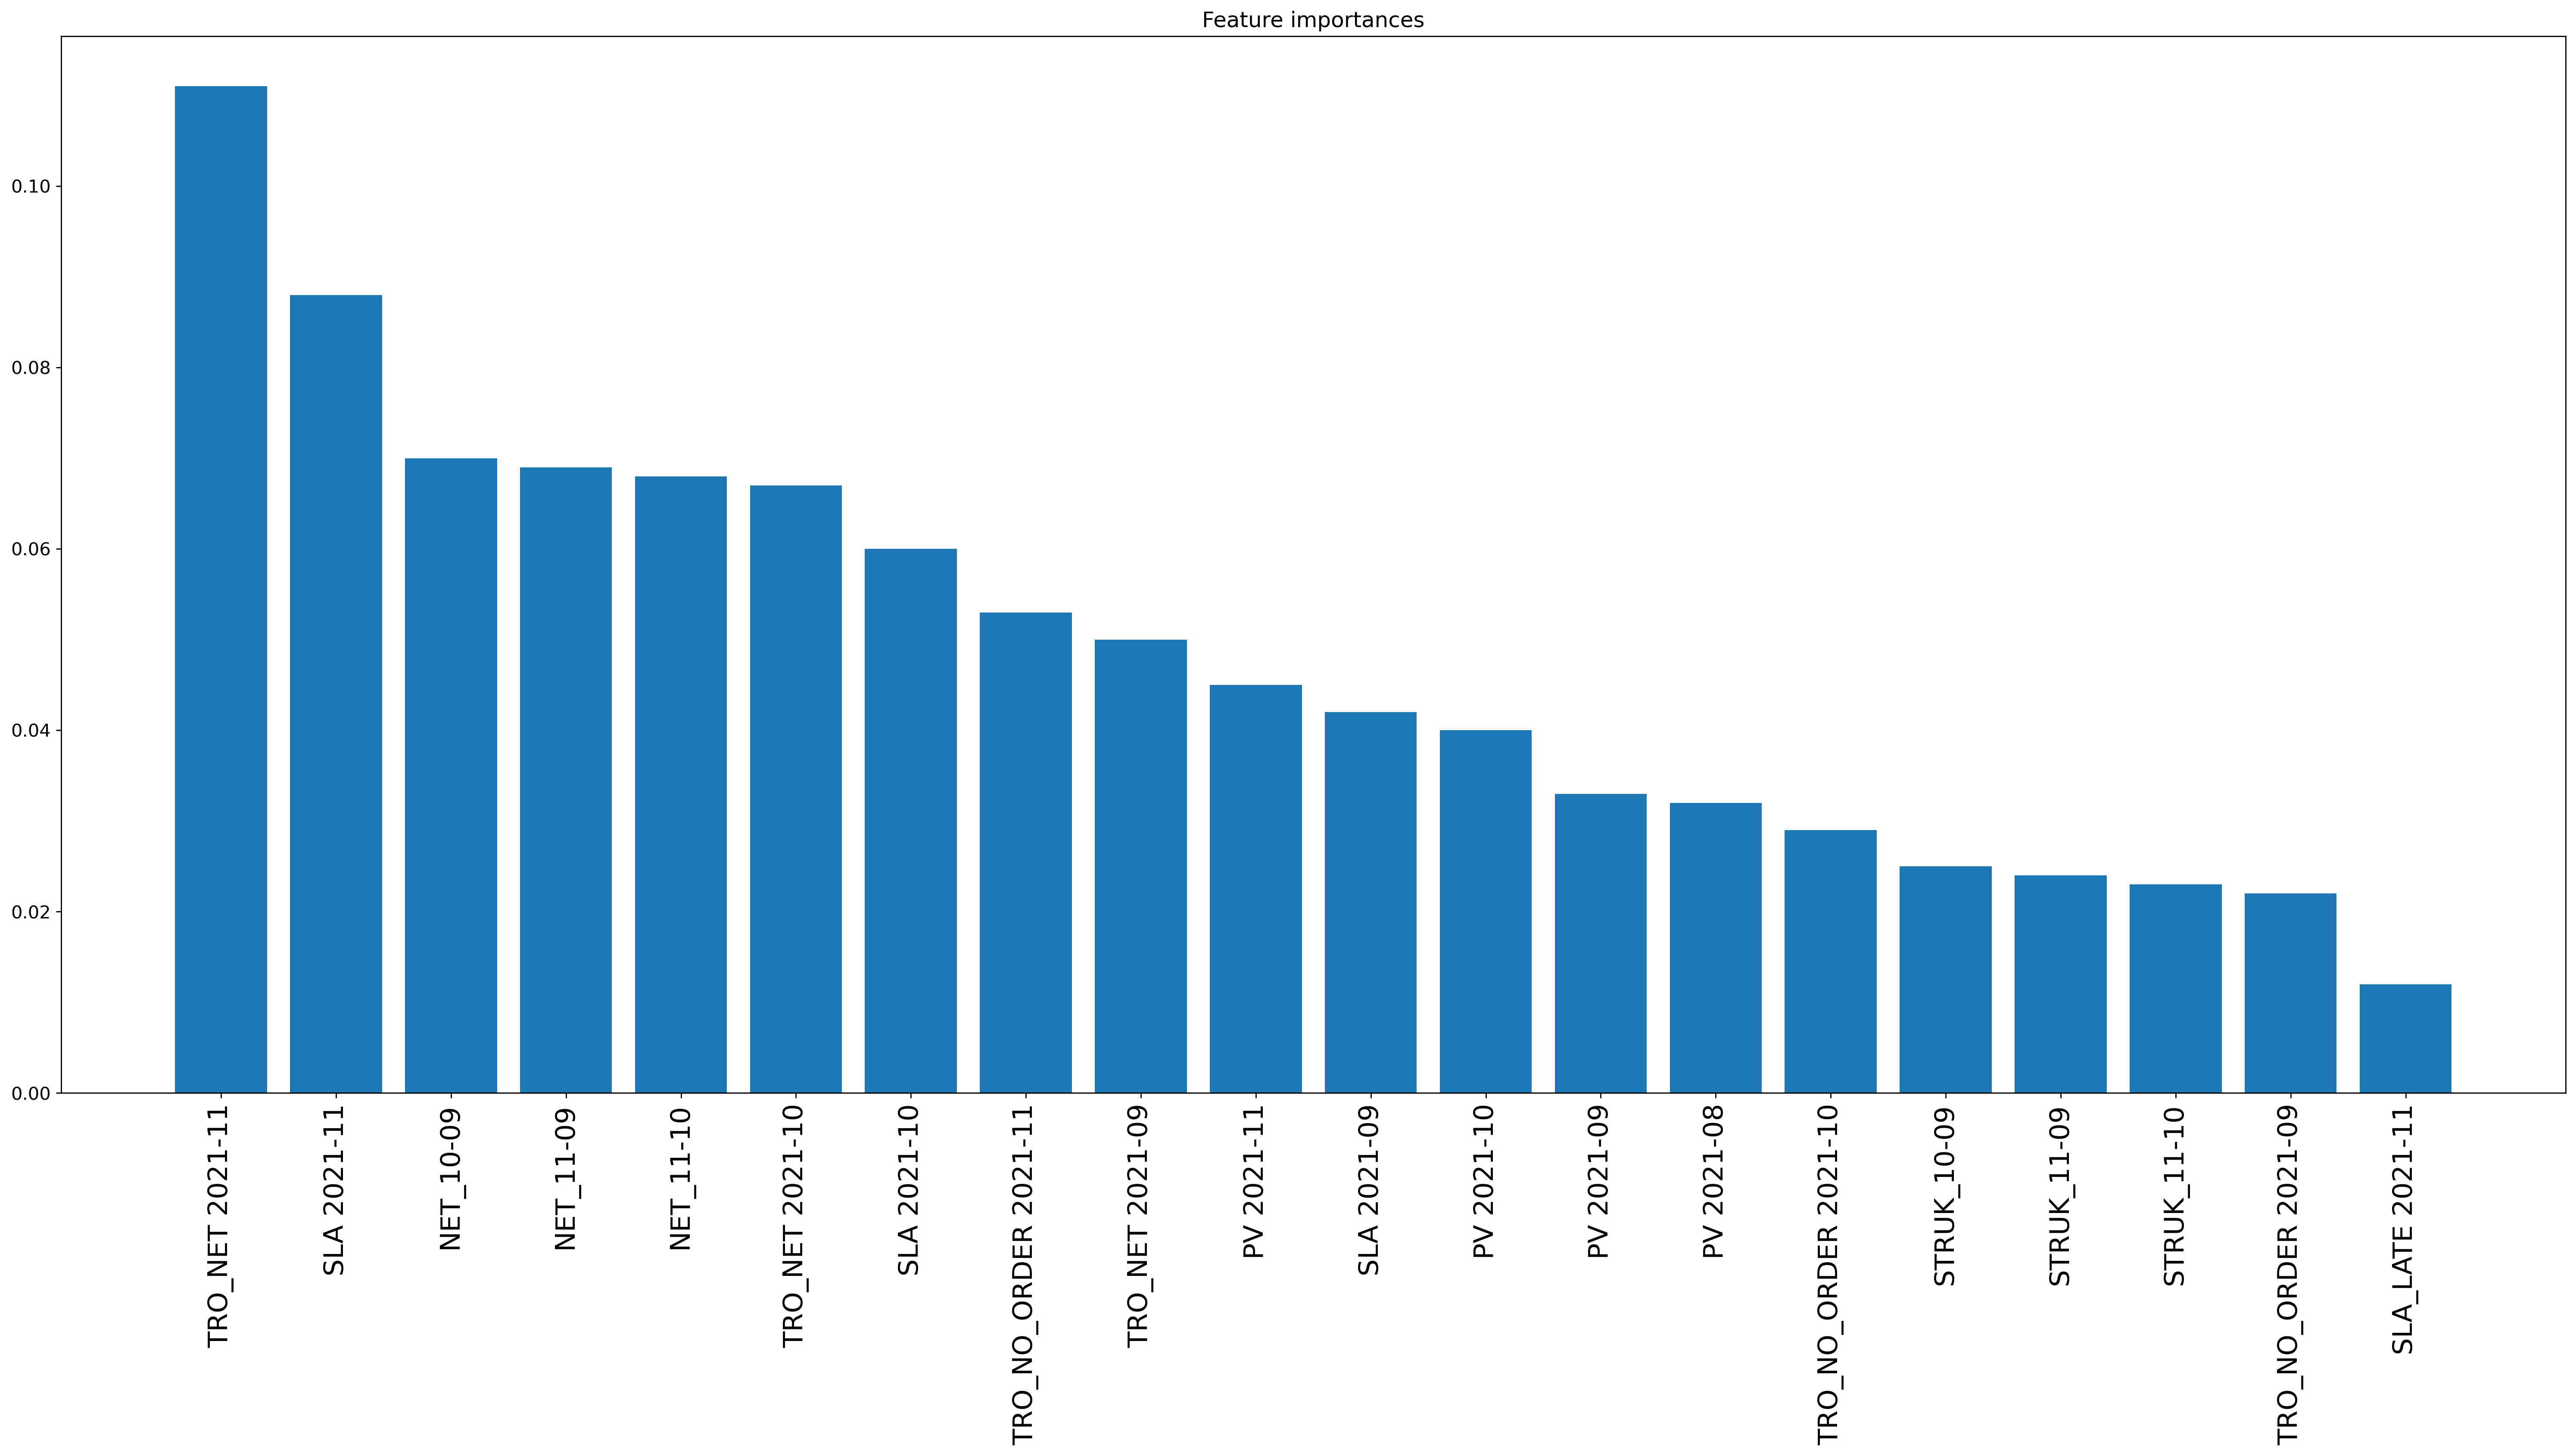

In [23]:
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(clf_ridge.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances = importances[0:20]
x_range = list(range(importances.shape[0]))
x_plot = list(importances.index)
y_plot = list(importances["importance"])
plt.figure(figsize=(30,13), dpi=250)
plt.title("Feature importances")
plt.bar(x_range, y_plot)
plt.xticks(x_range, x_plot, rotation='vertical', fontsize=18)
fig = plt.gcf()


### not oversampling version without threshold 3/3

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    197716
           1       0.48      0.06      0.10      5800

    accuracy                           0.97    203516
   macro avg       0.72      0.53      0.54    203516
weighted avg       0.96      0.97      0.96    203516



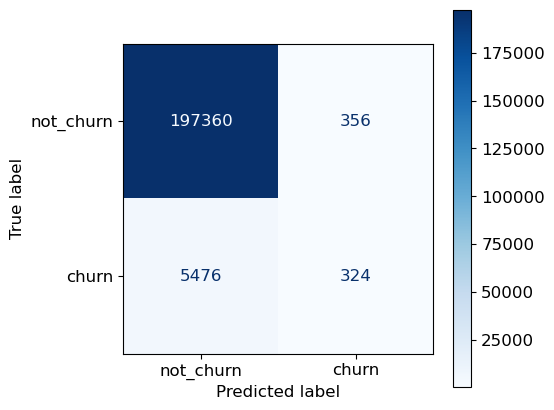

In [25]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = RandomForestClassifier(random_state=42) 
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

In [26]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

In [27]:
df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(10)

,TRO_MEMBERS,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA 2021-12,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,SLA_LATE 2021-12,RATING_BELOW 2021-08,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_BELOW 2021-12,RATING_AVG 2021-08,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,RATING_AVG 2021-12,PV 2021-08,PV 2021-09,PV 2021-10,PV 2021-11,PV 2021-12,NET_11-10,NET_10-09,NET_11-09,STRUK_11-10,STRUK_10-09,STRUK_11-09,pred,label
955,9990011364453598,36181.0,83316.0,111088.0,88633.0,1.0,1.0,1.0,1.0,23.6,50.2,2.8,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,27772.0,47135.0,74907.0,0.0,0.0,0.0,1,0
1168,9990013388877476,1608728.0,321320.0,32997.0,79268.0,26.0,7.0,1.0,2.0,477.2,152.5,20.0,22.6,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.7,5.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,1.0,-288323.0,-1287408.0,-1575731.0,-6.0,-19.0,-25.0,1,0
1200,9990013405916052,51178.0,94998.0,30362.0,60998.0,2.0,1.0,1.0,1.0,2485.8,1640.2,1505.3,1842.8,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,15.0,6.0,4.0,-64636.0,43820.0,-20816.0,0.0,-1.0,-1.0,1,0
1542,9990013223080739,17181.0,215270.0,196815.0,51725.0,1.0,5.0,2.0,1.0,1693.9,11414.0,3415.5,2431.4,1.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,7.0,17.0,10.0,5.0,-18455.0,198089.0,179634.0,-3.0,4.0,1.0,1,0
3164,9990013355425617,151770.0,135907.0,199223.0,284532.0,1.0,1.0,1.0,2.0,681.0,15.5,18.3,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,1.0,1.0,4.0,63316.0,-15863.0,47453.0,0.0,0.0,0.0,1,0
3198,9990012892156786,159449.0,116360.0,255359.0,123180.0,2.0,1.0,2.0,1.0,25.2,1374.6,3341.2,1558.7,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,5.0,7.0,1.0,5.0,138999.0,-43089.0,95910.0,1.0,-1.0,0.0,1,0
3435,9990013424202600,25181.0,25200.0,35500.0,70543.0,1.0,1.0,1.0,2.0,6.4,1854.2,1802.2,3459.5,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10300.0,19.0,10319.0,0.0,0.0,0.0,1,0
3454,9990013279825839,38998.0,73771.0,38271.0,256725.0,1.0,1.0,1.0,2.0,17.9,24.9,35.5,59.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0,2.0,5.0,0.0,-35500.0,34773.0,-727.0,0.0,0.0,0.0,1,0
3846,9990010658655366,1275789.0,2293702.0,26542.0,400957.0,115.0,148.0,3.0,40.0,193924.3,253745.5,4676.2,62723.6,114.0,143.0,3.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,13.0,14.0,0.0,2.0,-2267160.0,1017913.0,-1249247.0,-145.0,33.0,-112.0,1,0
3900,9990013427353500,17271.0,40724.0,9635.0,314634.0,1.0,1.0,1.0,2.0,781.9,13.8,7.4,19.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,-31089.0,23453.0,-7636.0,0.0,0.0,0.0,1,0


In [28]:
df_res[(df_res['label'] == 1) & (df_res['pred'] == 0)].head(10)

,TRO_MEMBERS,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA 2021-12,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,SLA_LATE 2021-12,RATING_BELOW 2021-08,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_BELOW 2021-12,RATING_AVG 2021-08,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,RATING_AVG 2021-12,PV 2021-08,PV 2021-09,PV 2021-10,PV 2021-11,PV 2021-12,NET_11-10,NET_10-09,NET_11-09,STRUK_11-10,STRUK_10-09,STRUK_11-09,pred,label
1,9990013381351449,332038.0,185587.0,59635.0,0.0,5.0,2.0,1.0,0.0,52.0,4.0,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,-125952.0,-146451.0,-272403.0,-1.0,-3.0,-4.0,0,1
6,9990013391613241,61907.0,103398.0,178543.0,0.0,1.0,1.0,1.0,0.0,645.4,20.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0,0.0,75145.0,41491.0,116636.0,0.0,0.0,0.0,0,1
30,9990013384144028,599893.0,386635.0,956996.0,0.0,2.0,1.0,3.0,0.0,40.0,20.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,6.0,14.0,570361.0,-213258.0,357103.0,2.0,-1.0,1.0,0,1
31,9990013307150388,365085.0,522541.0,148542.0,0.0,4.0,4.0,2.0,0.0,6823.7,6531.9,4504.2,0.0,4.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-373999.0,157456.0,-216543.0,-2.0,0.0,-2.0,0,1
74,9990013374310865,114541.0,124904.0,384216.0,0.0,1.0,1.0,3.0,0.0,11.9,24.3,30.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,66.0,35.0,4.0,259312.0,10363.0,269675.0,2.0,0.0,2.0,0,1
85,9990010649763720,822704.0,477894.0,189359.0,0.0,7.0,5.0,2.0,0.0,89.3,122.5,25.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,16.0,16.0,14.0,0.0,-288535.0,-344810.0,-633345.0,-3.0,-2.0,-5.0,0,1
117,9990013099879497,33362.0,200000.0,51181.0,0.0,1.0,1.0,1.0,0.0,4.7,1593.5,7.7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,53.0,69.0,86.0,54.0,-148819.0,166638.0,17819.0,0.0,0.0,0.0,0,1
124,9990013147429892,52590.0,110813.0,47134.0,0.0,1.0,4.0,1.0,0.0,1592.0,5697.0,79.7,0.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,16.0,3.0,7.0,-63679.0,58223.0,-5456.0,-3.0,3.0,0.0,0,1
169,9990010823603077,297989.0,295900.0,83359.0,0.0,4.0,5.0,2.0,0.0,86.2,175.8,149.7,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,10.0,23.0,9.0,6.0,6.0,-212541.0,-2089.0,-214630.0,-3.0,1.0,-2.0,0,1
229,9990013278408800,1008090.0,65363.0,235909.0,0.0,1.0,1.0,1.0,0.0,4.8,20.0,8.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,35.0,33.0,15.0,17.0,170546.0,-942727.0,-772181.0,0.0,0.0,0.0,0,1


## oversampling version 2/3

              precision    recall  f1-score   support

           0       0.97      0.94      0.96    189343
           1       0.43      0.55      0.48     14173

    accuracy                           0.92    203516
   macro avg       0.70      0.75      0.72    203516
weighted avg       0.93      0.92      0.92    203516



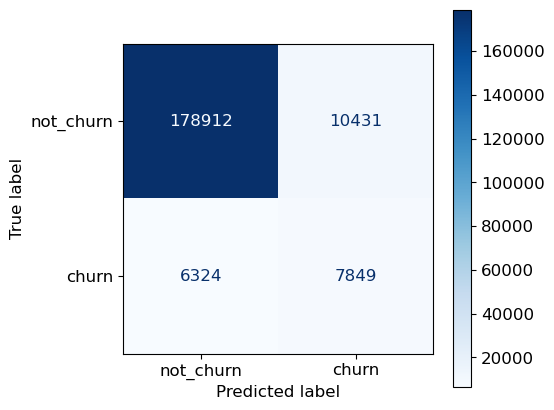

In [29]:
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)


from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=0)
X_train ,y_train = oversampler.fit_resample(X_train, y_train)


clf_ridge = RandomForestClassifier(n_jobs=32) 
clf_ridge.fit(X_train, y_train) 
# pred = clf_ridge.predict(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)


print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

## random over oversampling 3/3

In [ ]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)


from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=0)
X_train ,y_train = oversampler.fit_resample(X_train, y_train)


clf_ridge = RandomForestClassifier(n_jobs=32) 
clf_ridge.fit(X_train, y_train) 
# pred = clf_ridge.predict(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)


print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

In [ ]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

In [ ]:
df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(10)

In [ ]:
df_res[(df_res['label'] == 1) & (df_res['pred'] == 0)].head(10)

## XGBOOST

### not oversampling 2/3

In [ ]:
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1)
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')


### not oversampling version 3/3

In [ ]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = RandomForestClassifier(random_state=42) 
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

# MLP ( 2/3 )

In [ ]:
from sklearn.neural_network import MLPClassifier


condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,))
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')


In [ ]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,))
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

## MLP 2/3 oversampling

In [ ]:
from sklearn.neural_network import MLPClassifier


condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=0)
X_train ,y_train = oversampler.fit_resample(X_train, y_train)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,))
clf_ridge.fit(X_train, y_train) 



# pred = clf_ridge.predict(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [ ]:
condition = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,))
clf_ridge.fit(X_train, y_train) 

pred = clf_ridge.predict(X_test)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax, values_format = 'd')

## simple ruling (construct own)

In [ ]:

condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)




X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

condition_2_3 = (
((X_test['NET_11-10'] < 0) & \
(X_test['NET_10-09'] < 0) & \
(X_test['NET_11-09'] < 0)
)
)

pred = np.where(condition_2_3, 1, 0)




print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')